In [1]:
%matplotlib inline
%autosave 60

import sys
sys.path.append('../boresightUtils/')
import matplotlib.pyplot as plt
import numpy as np
import random
import os

from boresightUtils import *
from scipy.optimize import differential_evolution
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic
from scipy.signal import fftconvolve

Autosaving every 60 seconds


In [2]:
# Instrument Specs
focalLengths = [135, 375, 750]
whDegs = [(7.91, 5.93), (2.85, 2.13), (1.42, 1.07)] # Image width and height in Degrees
plateScales = [8.64, 3.11, 1.56] # plate scales of cameras in arcsec / px
whPxs = [convert_fov_degs_px(whDeg, plateScale) for whDeg, plateScale in zip(whDegs, plateScales)] 

# Notebook Configurables
camNum = 0 # Choose an instrument
figsDir = os.path.expanduser('~/Pictures/work/lsst/startracker/simulate_drift') # Where to save the figures
saveFig = True

# Parameters Derived / Selected from Configurables
focalLength = focalLengths[camNum]
plateScale = plateScales[camNum]
width, height = whPxs[camNum]
xMu = width / 2 
yMu = height / 2

In [3]:
driftSpeedArcSec = 13 # arcseconds / s
driftDir = np.array([[1], [0]]) # Drifting right in px space initially
driftVel = driftSpeedArcSec / (plateScale) * driftDir # Drift in px / s
nStars = 35

ims = []
thetaInits = [0, 0]
driftTimes = [0, 180]

seed = 1000 # 98735927 # Set a seed (optional)

for i, (thetaInit, driftTime) in enumerate(zip(thetaInits, driftTimes)):
    # numpy random Stuff
    if seed is None:
        rng = np.random.default_rng() # Make one of these things
    else:
        rng = np.random.default_rng(seed)

    # Dictionary of Configurables to pass to functions
    configDict = {
        'expTime': 0,
        'slewRate': 6,
        'driftVel': driftVel,
        'threshold': .3,
        'rng': rng,
        'imageWidth': width,
        'imageHeight': height,
        'gaussianBlurSigma': 1,
        'xMu': xMu,
        'yMu': yMu,
        'pointingSigma': 300,
        'nStars': nStars,
        }
    
    arcImg, pointingCenter = make_arc_image(configDict, thetaInit=thetaInit, driftTime=driftTime)
    ims.append(arcImg)

In [5]:
im0 = gaussian_blur_image(ims[0], configDict)
im1 = gaussian_blur_image(ims[1], configDict)

In [6]:
totalDrift = bsutil.measure_drift(im0, im1)
driftRateRC = totalDrift / driftTimes[1]
driftRate = np.array([[driftRateRC[1]], [-driftRateRC[0]]])
print(driftRate)
print(driftVel)
print(driftRate - driftVel)

[[ 1.50555556]
 [-0.        ]]
[[1.50462963]
 [0.        ]]
[[ 0.00092593]
 [-0.        ]]


In [7]:
configDict = {
    'expTime': 15,
    'slewRate': 6,
    'driftVel': driftRate,
    'threshold': 0.3,
    'rng': rng,
    'imageWidth': width,
    'imageHeight': height,
    'gaussianBlurSigma': 1,
    'xMu': xMu,
    'yMu': yMu,
    'pointingSigma': 300,
    'nStars': 35,
    }

biases = calculate_drift_bias(configDict)
bias = biases.mean(axis=0)

In [8]:
print(biases)

[[-12.23477506 -11.68427454]
 [-12.33845859 -11.54912712]
 [-11.10200178 -10.3054407 ]
 [-11.51946144 -11.09579791]
 [-12.08486727 -11.07637066]
 [-11.12037375 -10.10539389]
 [-11.40485841 -10.98080242]
 [-11.74891683 -11.72188179]
 [-12.07971013 -11.48877365]
 [-11.63266244 -11.44493688]]


In [9]:
arcImg, trueBoresight = make_arc_image(configDict, thetaInit=thetaInit, driftTime=driftTime)
nTrials = 10
boresights = np.zeros((nTrials, 2))

for i in range(nTrials):
    boresights[i] = find_boresight_naive(arcImg)

boresight = boresights.mean(axis=0) - bias

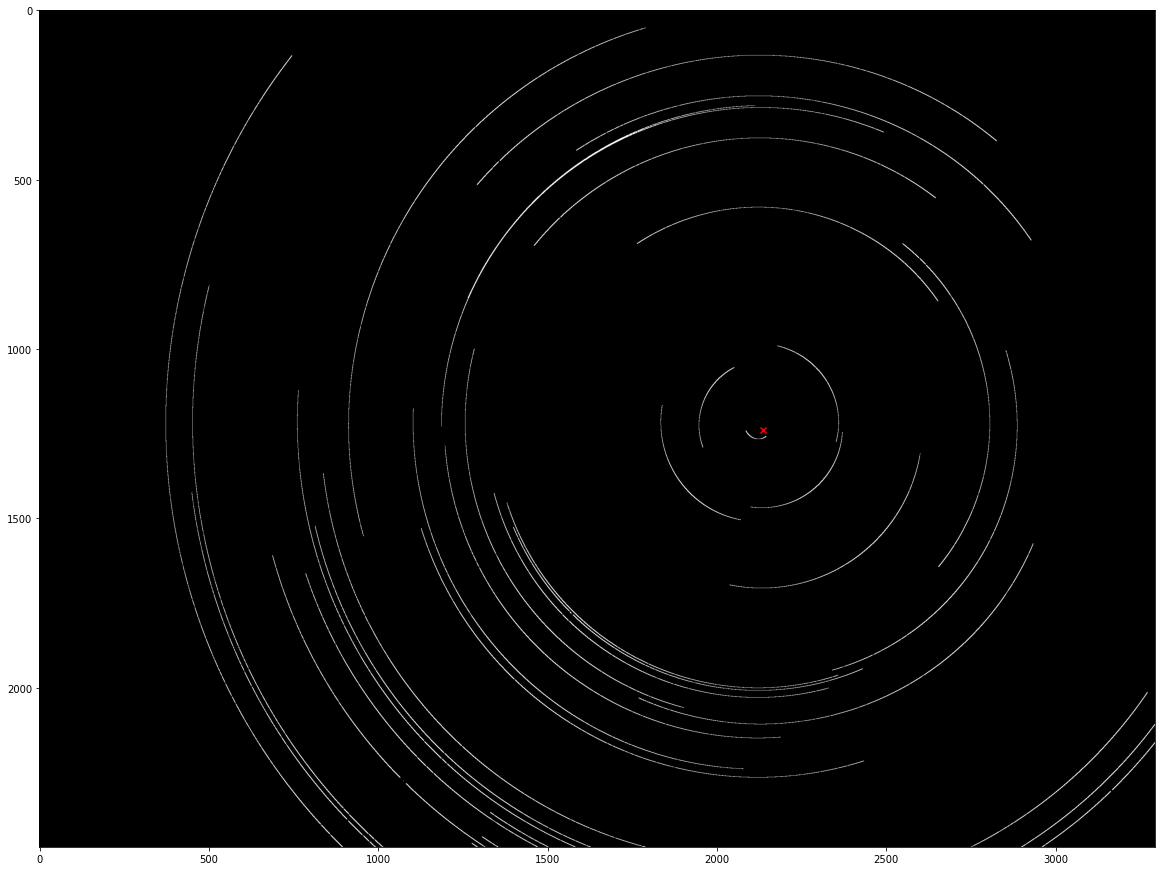

In [10]:
bpxs = make_threshold_image(arcImg, configDict)
plot_arc_image(bpxs, boresight=boresight)

In [11]:
trueBoresightIdx = xy_image_coord_transform(trueBoresight, bpxs)
print(boresight, trueBoresightIdx, boresight - trueBoresightIdx)

[1231.20365637 2136.06952277] [1230.58861958 2136.73176742] [ 0.61503679 -0.66224464]
